# Requirements

In [9]:
! pip install numpy pandas torch scikit-learn yfinance matplotlib seaborn

  Using cached matplotlib-3.9.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.4 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.3 kB)
  Using cached pillow-11.0.0-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (9.1 kB)
  Using cached pyparsing-3.2.0-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.9.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.3 MB)
Using cached contourpy-1.3.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (323 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 35.1 MB/s eta 0:00:00
Using cached kiwisolver-1.4.7-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.5 MB)
Using cached pillow-11.0.0-cp312-cp31

# Data Preparation

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset

In [5]:
# Define the ticker symbol
ticker_symbol = "AAPL"

# Create a Ticker object
ticker = yf.Ticker(ticker_symbol)

# Fetch historical market data
historical_data = ticker.history(period='max')
print("Historical Data:")
historical_data

Historical Data:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,73449600,0.0,0.0
...,...,...,...,...,...,...,...
2024-12-06 00:00:00-05:00,242.910004,244.630005,242.080002,242.839996,36870600,0.0,0.0
2024-12-09 00:00:00-05:00,241.830002,247.240005,241.750000,246.750000,44649200,0.0,0.0
2024-12-10 00:00:00-05:00,246.889999,248.210007,245.339996,247.770004,36914800,0.0,0.0


In [6]:
# Feature Engineering
df = historical_data.copy()
df['Return'] = df['Close'].pct_change()
df['Volume Change'] = df['Volume'] - df['Volume'].shift(1)
df['MA_3'] = df['Close'].rolling(window=3).mean()
df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()
df['MA_90'] = df['Close'].rolling(window=90).mean()
df['MA_Signal_1_3'] = df['Close'] - df['MA_3']
df['MA_Signal_3_7'] = df['MA_3'] - df['MA_7']
df['MA_Signal_7_14'] = df['MA_7'] - df['MA_14']
df['MA_Signal_14_30'] = df['MA_14'] - df['MA_30']
df['MA_Signal_30_90'] = df['MA_30'] - df['MA_90']
df['MA_Factor_1_3'] = df['MA_Signal_1_3'] / df['MA_3']
df['MA_Factor_3_7'] = df['MA_Signal_3_7'] / df['MA_7']
df['MA_Factor_7_14'] = df['MA_Signal_7_14'] / df['MA_14']
df['MA_Factor_14_30'] = df['MA_Signal_14_30'] / df['MA_30']
df['MA_Factor_30_90'] = df['MA_Signal_30_90'] / df['MA_90']
df = df[[# 'MA_3', 'MA_7', 'MA_14', 'MA_30',
        # 'MA_Signal_1_3', 'MA_Signal_3_7', 'MA_Signal_7_14', 'MA_Signal_14_30',
        'MA_Factor_1_3', 'MA_Factor_3_7', 'MA_Factor_7_14', 'MA_Factor_14_30', 'MA_Factor_30_90',
        # 'Close', 'High', 'Low',
        # 'Volume', 'Volume Change',
        'Return']].dropna()

TARGET_VAL = 'Return'

In [7]:
df.head()

,MA_Factor_1_3,MA_Factor_3_7,MA_Factor_7_14,MA_Factor_14_30,MA_Factor_30_90,Return
Date,,,,,,
1981-04-22 00:00:00-05:00,0.045871,0.009258,0.005319,0.046213,-0.079119,0.036361
1981-04-23 00:00:00-05:00,0.029323,0.044867,0.004949,0.043877,-0.070187,0.026314
1981-04-24 00:00:00-05:00,0.002882,0.057005,0.004261,0.042055,-0.063069,-0.008547
1981-04-27 00:00:00-04:00,-0.008620,0.047741,0.008785,0.040942,-0.056619,-0.008620
1981-04-28 00:00:00-04:00,-0.014534,0.018612,0.019074,0.040970,-0.051401,-0.017390


In [8]:
df.describe()

,MA_Factor_1_3,MA_Factor_3_7,MA_Factor_7_14,MA_Factor_14_30,MA_Factor_30_90,Return
count,11004.000000,11004.000000,11004.000000,11004.000000,11004.000000,11004.000000
mean,0.000764,0.001477,0.002511,0.005826,0.022989,0.001106
std,0.020950,0.024720,0.030216,0.047770,0.107927,0.027707
min,-0.397368,-0.396722,-0.399380,-0.458225,-0.514995,-0.518692
25%,-0.009261,-0.011080,-0.013662,-0.020083,-0.033391,-0.012560
50%,0.000921,0.001700,0.003318,0.008070,0.031555,0.000000
75%,0.010822,0.014340,0.019907,0.035044,0.091806,0.014346
max,0.199432,0.211751,0.176027,0.198848,0.377530,0.332281


<Axes: xlabel='Date'>

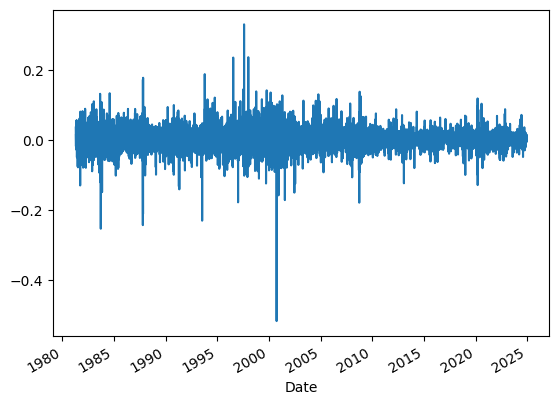

In [9]:
df.Return.plot()

<Axes: xlabel='Date'>

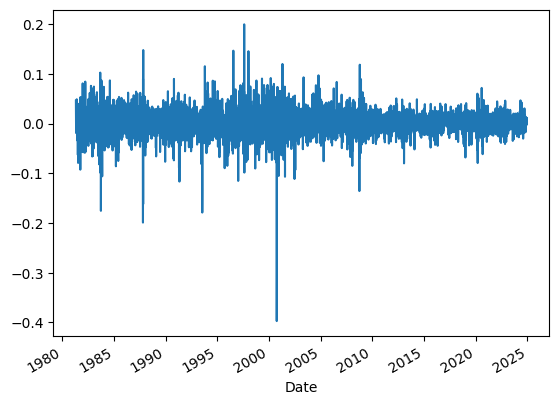

In [10]:
df.MA_Factor_1_3.plot()

<Axes: xlabel='Date'>

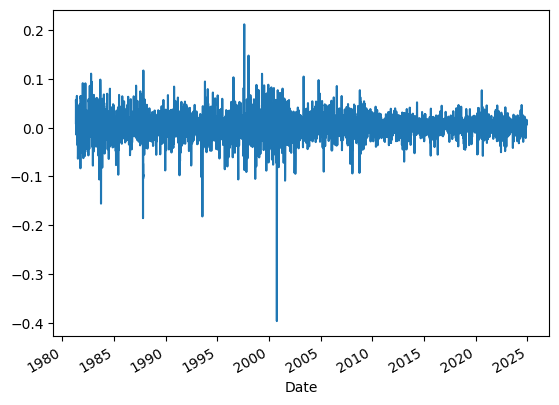

In [11]:
df.MA_Factor_3_7.plot()

<Axes: xlabel='Date'>

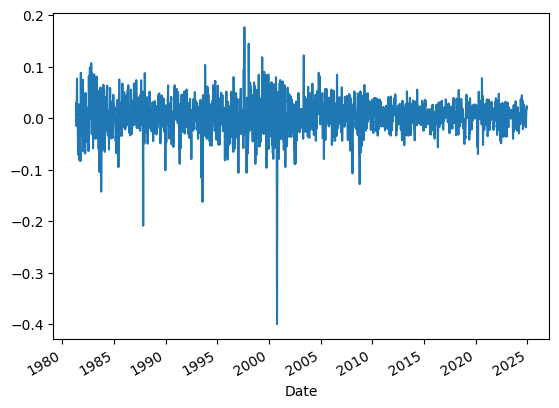

In [12]:
df.MA_Factor_7_14.plot()

In [13]:
df_over_time = df.copy()

for i in range(1, 8):
  df_over_time[f'MA_Factor_1_3_D{i}'] = df_over_time['MA_Factor_1_3'].shift(i)
  df_over_time[f'MA_Factor_3_7_D{i}'] = df_over_time['MA_Factor_3_7'].shift(i)
  df_over_time[f'MA_Factor_7_14_D{i}'] = df_over_time['MA_Factor_7_14'].shift(i)
  df_over_time[f'Return_D{i}'] = df_over_time['Return'].shift(i)

df_over_time = df_over_time.dropna()

In [14]:
df_over_time.drop(columns=[col for col in df_over_time.columns if col.startswith('MA') and len(col.split('_'))==4])\
            .corr()['Return']\
            .sort_values(key=abs, ascending=False)

Return               1.000000
MA_Factor_1_3_D2    -0.036812
Return_D3           -0.031633
Return_D2           -0.026929
MA_Factor_1_3_D4     0.026926
Return_D4            0.026820
MA_Factor_7_14_D7    0.020532
MA_Factor_7_14_D6    0.018314
MA_Factor_1_3_D3    -0.014785
MA_Factor_3_7_D3     0.013092
Return_D1            0.012509
MA_Factor_3_7_D4     0.012371
MA_Factor_7_14_D5    0.012204
MA_Factor_3_7_D6    -0.011452
MA_Factor_3_7_D1    -0.010987
MA_Factor_3_7_D7    -0.010703
MA_Factor_1_3_D6     0.009815
Return_D6            0.009682
MA_Factor_1_3_D5     0.008743
MA_Factor_7_14_D4    0.007487
MA_Factor_3_7_D2     0.005472
MA_Factor_7_14_D3    0.005356
Return_D5            0.004720
MA_Factor_3_7_D5    -0.002710
MA_Factor_7_14_D2    0.001845
Return_D7            0.001454
MA_Factor_1_3_D7    -0.000821
MA_Factor_1_3_D1     0.000474
MA_Factor_7_14_D1    0.000156
Name: Return, dtype: float64

In [15]:
# Splitting the data
df_train = df[:-730]
df_test = df[-730:-365]
df_backtest = df[-365:]

In [16]:
print('Training Period:', df_train.index.min(), df_train.index.max())
print('Validation Period:', df_test.index.min(), df_test.index.max())
print('Backtest Period:', df_backtest.index.min(), df_backtest.index.max())

Training Period: 1981-04-22 00:00:00-05:00 2022-01-18 00:00:00-05:00
Validation Period: 2022-01-19 00:00:00-05:00 2023-07-03 00:00:00-04:00
Backtest Period: 2023-07-05 00:00:00-04:00 2024-12-12 00:00:00-05:00


In [17]:
# Scaling the features
scaler = StandardScaler()

n_features = df_train.shape[1]

df_train_scaled = scaler.fit_transform(df_train)
y_train = df_train[[TARGET_VAL]].to_numpy().reshape(-1, 1)

df_test_scaled = scaler.transform(df_test)
y_test = df_test[[TARGET_VAL]].to_numpy().reshape(-1, 1)

In [18]:
# Sequence Data Preparation
SEQUENCE_SIZE = 7

def to_sequences(seq_size, obs_x, obs_y, n_features=1, predicted_index=-1):
    x = []
    y = []
    for i in range(len(obs_x) - seq_size):
        window = obs_x[i:(i + seq_size)]
        after_window = obs_y[i + seq_size]
        x.append(window)
        y.append(after_window)
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, n_features), torch.tensor(y, dtype=torch.float32).view(-1, 1)

x_train, y_train = to_sequences(SEQUENCE_SIZE, df_train_scaled, y_train, n_features=df_train_scaled.shape[1])
x_test, y_test = to_sequences(SEQUENCE_SIZE, df_test_scaled, y_test, n_features=df_test_scaled.shape[1])

/tmp/ipykernel_400714/3119829853.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, n_features), torch.tensor(y, dtype=torch.float32).view(-1, 1)


In [19]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

(torch.Size([10267, 7, 6]),
 torch.Size([10267, 1]),
 torch.Size([358, 7, 6]),
 torch.Size([358, 1]))

In [20]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Neural Nets



In [21]:
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [22]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [23]:
class TransformerRegressor(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, n_encoder_layers=2, dropout=0.2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.decoder(x[:, -1, :])
        return x

In [24]:
class LSTMRegressor(nn.Module):
    def __init__(self, input_dim=1, d_model=64, lstm_hidden_size=8, n_lstm_layers=1, dropout=0.2):
        super().__init__()
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.lstm = nn.LSTM(d_model, hidden_size=lstm_hidden_size, num_layers=n_lstm_layers)
        self.linear = nn.Linear(lstm_hidden_size, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x, _ = self.lstm(x)
        x = self.linear(x[:,-1,:])
        return x

In [25]:
class ModelTrainer:
    def __init__(self, model,
                 criterion=nn.MSELoss(),
                 optimizer_class=torch.optim.Adam,
                 lr=0.001,
                 lr_reduce_factor=0.5,
                 lr_reduce_patience=3):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer_class(model.parameters(), lr=lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, 'min', factor=0.5, patience=3, verbose=True)

    def train(self, train_loader, test_loader, epochs = 1000, early_stop_threshold=5, buy_threshold=0.005):
        early_stop_count = 0
        min_val_loss = float('inf')

        for epoch in range(epochs):
            model.train()
            for batch in train_loader:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                self.optimizer.zero_grad()
                outputs = model(x_batch)
                loss = self.criterion(outputs, y_batch)
                loss.backward()
                self.optimizer.step()

            # Validation
            model.eval()
            val_losses = []
            init_amt = 100
            amt = init_amt
            with torch.no_grad():
                for batch in test_loader:
                    x_batch, y_batch = batch
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                    outputs = model(x_batch)
                    loss = self.criterion(outputs, y_batch)
                    val_losses.append(loss.item())

                    for i, p in enumerate(outputs.squeeze().tolist()):
                      if p > buy_threshold:
                        amt *= (1+y_test[i])

            val_loss = np.mean(val_losses)
            self.scheduler.step(val_loss)

            if val_loss < min_val_loss:
                min_val_loss = val_loss
                early_stop_count = 0
            else:
                early_stop_count += 1

            if early_stop_count >= early_stop_threshold:
                print("Early stopping!")
                break
            print(f"Epoch {epoch + 1}/{epochs}, Validation Loss: {val_loss:.9f},", f'Return: {round(float(amt), 2)}$')

        return min_val_loss

# Training

In [50]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, f1_score, recall_score, precision_score
import seaborn as sns

In [51]:
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


In [52]:
torch.manual_seed(0)

In [64]:
def plot_simulation(title, prices, events_list):
    plt.figure(figsize=(15,5))
    plt.plot(prices)

    y_lims = (int(prices.min()*.95), int(prices.max()*1.05))
    shaded_y_lims = int(prices.min()*.5), int(prices.max()*1.5)

    for idx, event in enumerate(events_list):
        plt.axvline(event[1], color='k', linestyle='--', alpha=0.4)
        if event[0] == 's':
            color = 'green' if event[2] > 0 else 'red'
            plt.fill_betweenx(range(*shaded_y_lims),
                              event[1], events_list[idx-1][1], color=color, alpha=0.1)

    plt.title(title)
    plt.ylim(*y_lims)
    plt.show()


def simulate(model, test_loader, df_test, prices, ticker_symbol, thresh=0, sequence_len=7):
    prices = prices[df_test.index.min():df_test.index.max()]

    predictions = []
    y_test = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predictions.extend(outputs.squeeze().tolist())
            y_test.extend(y_batch.squeeze().tolist())

    predictions = np.array(predictions)
    y_test = np.array(y_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    accuracy = accuracy_score(y_test > 0, predictions > 0)
    recall = recall_score(y_test > 0, predictions > 0)
    precision = precision_score(y_test > 0, predictions > 0)
    f1 = 2 * f1_score(y_test > 0, predictions > 0)
    
    init_amt = 100
    amt = init_amt
    amt_holding_start = None
    holding = False
    events_list = []
    buy_and_hold_return = init_amt
    
    for i, p in enumerate(predictions):
        next_day_idx = i + sequence_len
        today_idx = next_day_idx - 1
        
        if (p > thresh) and not holding:
            events_list.append(('b', df_test.index[today_idx], None))
            holding = True
            amt_holding_start = amt
        elif (p <= thresh) and holding:
            events_list.append(('s', df_test.index[today_idx], amt - amt_holding_start))
            holding = False

        if holding:
            amt *= 1 + df_test.iloc[next_day_idx]['Return']

        buy_and_hold_return *= 1 + df_test.iloc[next_day_idx]['Return']

    title = f'{ticker_symbol} Price Data'
    title += f'\nThresh = {thresh} Return: {round(amt.item(),2)}%, Baseline Return (Buy & Hold): {round(buy_and_hold_return, 2)}%'
    title += f'\nRMSE: {round(rmse, 6)}, R2: {round(r2, 2)}, Direction Accuracy: {round(accuracy,2)*100}%'
    title += f'\nF1-Score: {round(f1,2)}, Recall: {round(recall,2)}, Precision: {round(precision,2)}'

    plot_simulation(title, prices, events_list)

## LSTM

In [65]:
model = LSTMRegressor(input_dim=6, d_model=8, lstm_hidden_size=4, n_lstm_layers=1, dropout=0.1).to(device)
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, early_stop_threshold=5)

/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/1000, Validation Loss: 0.000791258, Return: 112.63$
Epoch 2/1000, Validation Loss: 0.000503134, Return: 171.13$
Epoch 3/1000, Validation Loss: 0.000454888, Return: 211.49$
Epoch 4/1000, Validation Loss: 0.000430149, Return: 214.16$
Epoch 5/1000, Validation Loss: 0.000417489, Return: 207.91$
Epoch 6/1000, Validation Loss: 0.000409696, Return: 230.34$
Epoch 7/1000, Validation Loss: 0.000404342, Return: 217.43$
Epoch 8/1000, Validation Loss: 0.000400919, Return: 233.25$
Epoch 9/1000, Validation Loss: 0.000397906, Return: 213.59$
Epoch 10/1000, Validation Loss: 0.000396918, Return: 176.02$
Epoch 11/1000, Validation Loss: 0.000396194, Return: 152.51$
Epoch 12/1000, Validation Loss: 0.000395076, Return: 142.56$
Epoch 13/1000, Validation Loss: 0.000394334, Return: 116.56$
Epoch 14/1000, Validation Loss: 0.000393844, Return: 116.56$
Epoch 15/1000, Validation Loss: 0.000394056, Return: 101.85$
Epoch 16/1000, Validation Loss: 0.000392167, Return: 101.85$
Epoch 17/1000, Validation Loss: 0

np.float64(0.00039216718505485915)

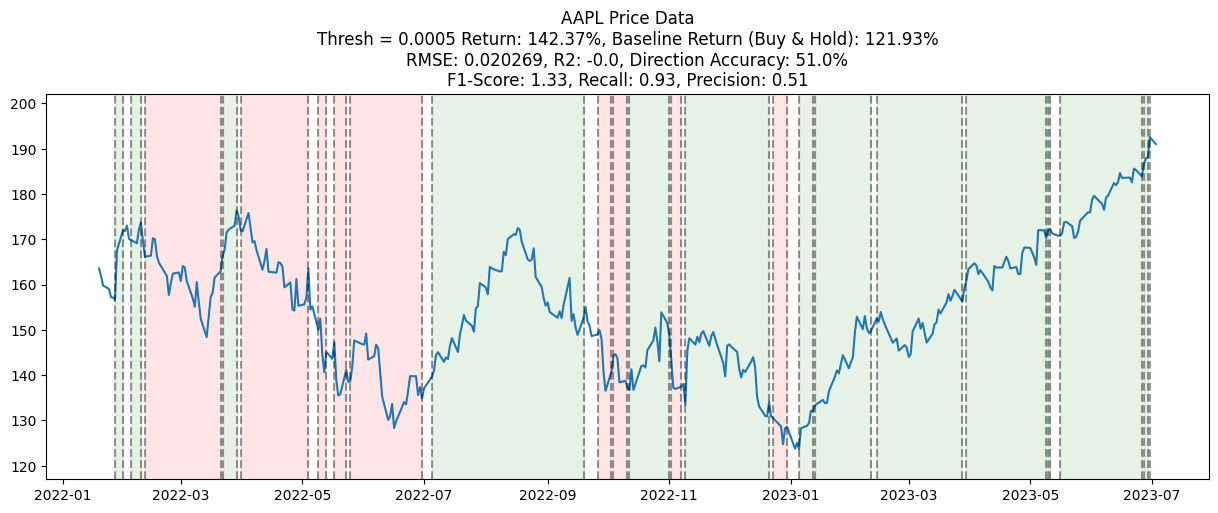

In [66]:
simulate(model, test_loader, df_test, historical_data['Close'], ticker_symbol, thresh=0.0005)

In [67]:
# torch.save(model, 'stock_lstm.pt')
# torch.save(model.state_dict(), 'stock_lstm_state_dict.pt')

## Transformer

In [1108]:
model = TransformerRegressor(input_dim=6, d_model=8, nhead=2, n_encoder_layers=1, dropout=0.1).to(device)
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, early_stop_threshold=5)

Epoch 1/1000, Validation Loss: 0.000531371, Return: 177.79$
Epoch 2/1000, Validation Loss: 0.000437112, Return: 56.42$
Epoch 3/1000, Validation Loss: 0.000420429, Return: 51.7$
Epoch 4/1000, Validation Loss: 0.000406457, Return: 86.65$
Epoch 5/1000, Validation Loss: 0.000404970, Return: 86.09$
Epoch 6/1000, Validation Loss: 0.000402535, Return: 111.86$
Epoch 7/1000, Validation Loss: 0.000400351, Return: 99.44$
Epoch 8/1000, Validation Loss: 0.000396628, Return: 143.31$
Epoch 9/1000, Validation Loss: 0.000399040, Return: 233.29$
Epoch 10/1000, Validation Loss: 0.000394360, Return: 127.7$
Epoch 11/1000, Validation Loss: 0.000396439, Return: 133.1$
Epoch 12/1000, Validation Loss: 0.000408315, Return: 32.57$
Epoch 13/1000, Validation Loss: 0.000397667, Return: 85.4$
Epoch 14/1000, Validation Loss: 0.000391157, Return: 103.06$
Epoch 15/1000, Validation Loss: 0.000394475, Return: 114.62$
Epoch 16/1000, Validation Loss: 0.000388983, Return: 97.29$
Epoch 17/1000, Validation Loss: 0.000389470, 

0.000304581113596214

In [ ]:
# torch.save(model, 'stock_transformer.pt')
# torch.save(model.state_dict(), 'stock_transformer_state_dict.pt')

In [68]:
model = torch.load('models/stock_transformer.pt')

/tmp/ipykernel_400714/1498100029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer.pt')


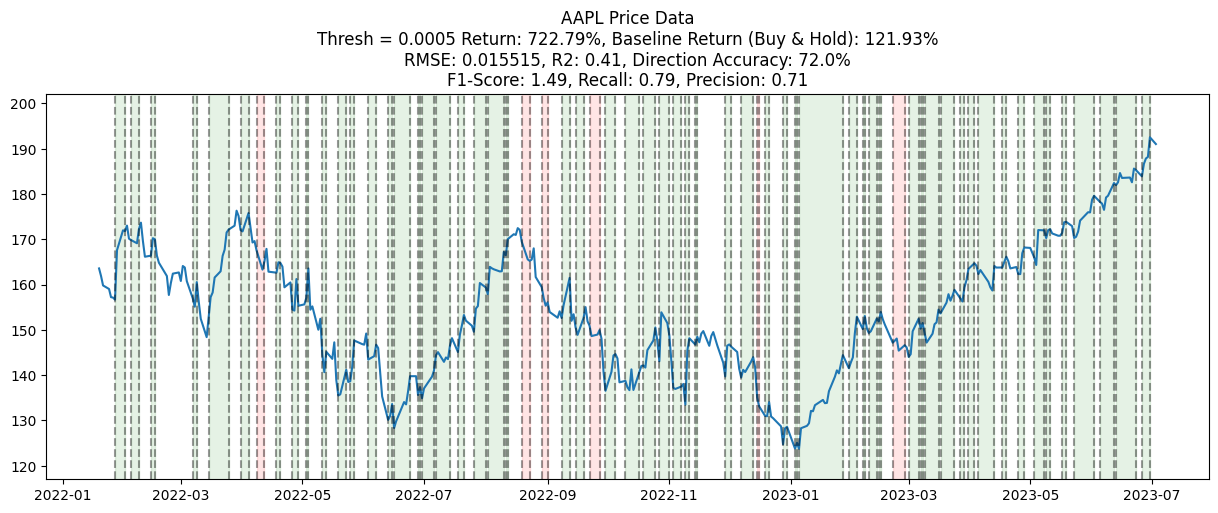

In [69]:
simulate(model, test_loader, df_test, historical_data['Close'], ticker_symbol, thresh=0.0005)

## Backtest

In [70]:
model = torch.load('models/stock_transformer.pt')

/tmp/ipykernel_400714/1498100029.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer.pt')


In [71]:
backtest_train = pd.concat([df_train, df_test])

In [72]:
scaler = StandardScaler()

backtest_train_scaled = scaler.fit_transform(backtest_train)
y_backtest_train = backtest_train[[TARGET_VAL]].to_numpy().reshape(-1, 1)

backtest_scaled = scaler.transform(df_backtest)
y_backtest = df_backtest[[TARGET_VAL]].to_numpy().reshape(-1, 1)

In [73]:
backtest_train_scaled.shape, y_backtest_train.shape, backtest_scaled.shape, y_backtest.shape

((10639, 6), (10639, 1), (365, 6), (365, 1))

In [74]:
x_backtest_train, y_backtest_train = to_sequences(SEQUENCE_SIZE, backtest_train_scaled, y_backtest_train, n_features=backtest_train_scaled.shape[1])
x_backtest, y_backtest = to_sequences(SEQUENCE_SIZE, backtest_scaled, y_backtest, n_features=backtest_scaled.shape[1])

In [75]:
x_backtest_train.shape, y_backtest_train.shape, x_backtest.shape, y_backtest.shape

(torch.Size([10632, 7, 6]),
 torch.Size([10632, 1]),
 torch.Size([358, 7, 6]),
 torch.Size([358, 1]))

In [76]:
train_dataset = TensorDataset(x_backtest_train, y_backtest_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(x_backtest, y_backtest)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
trainer = ModelTrainer(model, lr=0.001)
trainer.train(train_loader, test_loader, epochs=30, early_stop_threshold=30)

/home/user/Git/stock_price_prediction/venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Validation Loss: 0.000128029, Return: 106.99$
Epoch 2/30, Validation Loss: 0.000111721, Return: 115.15$
Epoch 3/30, Validation Loss: 0.000114152, Return: 74.04$
Epoch 4/30, Validation Loss: 0.000110580, Return: 107.4$
Epoch 5/30, Validation Loss: 0.000117916, Return: 104.44$
Epoch 6/30, Validation Loss: 0.000109636, Return: 100.85$
Epoch 7/30, Validation Loss: 0.000109024, Return: 108.39$
Epoch 8/30, Validation Loss: 0.000108757, Return: 102.78$
Epoch 9/30, Validation Loss: 0.000107217, Return: 111.23$
Epoch 10/30, Validation Loss: 0.000111870, Return: 107.25$
Epoch 11/30, Validation Loss: 0.000107232, Return: 107.05$
Epoch 12/30, Validation Loss: 0.000109345, Return: 112.27$
Epoch 13/30, Validation Loss: 0.000112694, Return: 87.43$
Epoch 14/30, Validation Loss: 0.000106387, Return: 98.66$
Epoch 15/30, Validation Loss: 0.000105917, Return: 89.67$
Epoch 16/30, Validation Loss: 0.000107293, Return: 114.09$
Epoch 17/30, Validation Loss: 0.000104556, Return: 108.87$
Epoch 18/30

np.float64(0.00010038548892528827)

In [38]:
# torch.save(model, 'stock_transformer_backtest.pt')
# torch.save(model.state_dict(), 'stock_transformer_state_dict_backtest.pt')

In [77]:
model = torch.load('models/stock_transformer_backtest.pt')

/tmp/ipykernel_400714/3684998795.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('models/stock_transformer_backtest.pt')


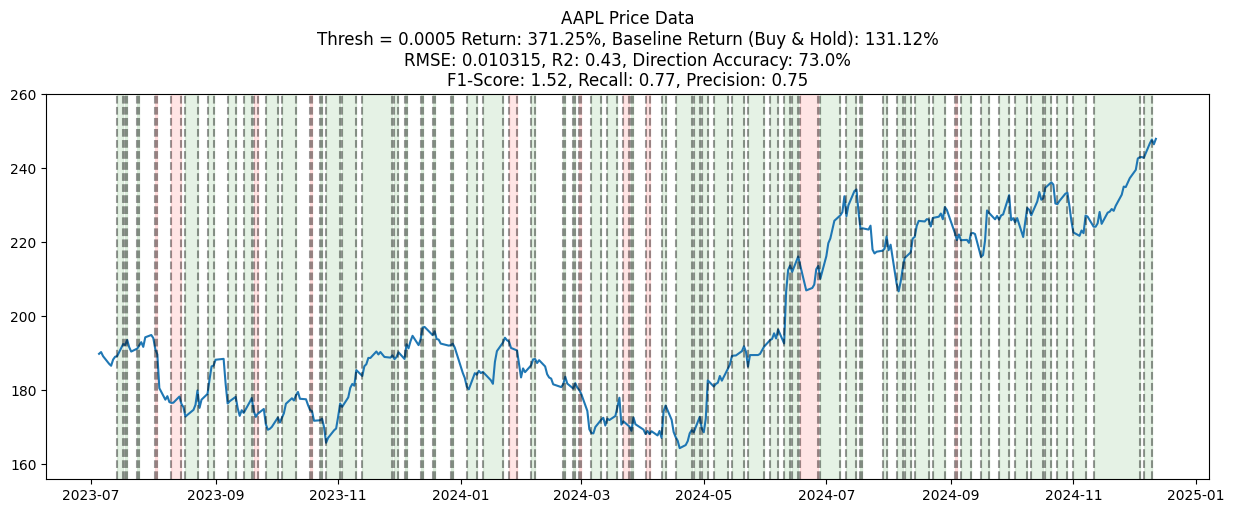

In [78]:
simulate(model, test_loader, df_backtest, historical_data['Close'], ticker_symbol, thresh=0.0005)